In [52]:
# newsAPI     =    0b1ea46e336d40e1abc48f51e01c253a

In [15]:
import pandas as pd
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
# from collections import defaultdict
# from datetime import timedelta


## load the data

In [3]:
df = pd.read_csv('testData.csv')

# convert the publish_date column to datetime64
df['publish_date'] = pd.to_datetime(df['publish_date'])

# convert remaining cols to string
df['headline_text'] = df['headline_text'].astype(str)
df['description'] = df['description'].astype(str)


headlines_df = df.copy()
headlines_df['headline_sentiment'] = 0
headlines_df['description_sentiment'] = 0
headlines_df['emotion'] = 0
# headlines_df['pos_sentiment'] = 0
# headlines_df['neg_sentiment'] = 0

print(headlines_df.dtypes)
headlines_df.head()

total_headlines = len(headlines_df)

headlines = df['headline_text'].tolist()
descriptions = df['description'].tolist()

publish_date             datetime64[ns, UTC]
headline_text                         object
description                           object
headline_sentiment                     int64
description_sentiment                  int64
emotion                                int64
dtype: object


In [25]:
valid_emotions = ['joy', 'others', 'surprise',
                  'sadness', 'fear', 'anger', 'disgust']


emotions =  {"joy": 0, "others": 0, "surprise": 0, 
             "sadness": 0, "fear": 0, "anger": 0, "disgust": 0}


keywords = {}

# emotions = {}


## load the models

In [5]:
# sentiments = defaultdict(lambda: defaultdict(int))
sentiment_model = pipeline(
    model="siebert/sentiment-roberta-large-english")  # Use device 0 for GPU

emotion_model = pipeline(
    model="finiteautomata/bertweet-base-emotion-analysis")

keyword_ext_model = pipeline(
    model="yanekyuk/bert-keyword-extractor")

keyword_senti_model = pipeline(
    model="cardiffnlp/twitter-roberta-base-sentiment-latest")


/opt/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exact

## helper methods

In [6]:
def extract_keywords(batch_headlines):
    batch_results = keyword_ext_model(batch_headlines)

    # keywords = {}

    # print(batch_results)

    for result in batch_results:
        # for keyword_info in result:
        # print(result)
        keyword = result['word']
        # print(keyword)
        # Filter words with less than 2 letters, exclude hashtags, and exclude "chin"
        if keyword and len(keyword) >= 3 and not keyword.startswith('#') and keyword.lower() != 'chin':
            if keyword in keywords.keys():
                keywords[keyword] += 1
            else:
                keywords[keyword] = 1

    return keywords

In [32]:
## analyse headlines ##
with tqdm(total=total_headlines, desc="Analysing Sentiments", unit="headline", dynamic_ncols=True) as pbar:
    for idx in range(total_headlines):
        row = headlines_df.iloc[idx]
        headline = row['headline_text']
        description = row['description']


        result = sentiment_model(headline)
        label = result[0]['label']

        if label == 'POSITIVE':
            headlines_df.at[idx, 'headline_sentiment'] = 1
        elif label == 'NEGATIVE':
            headlines_df.at[idx, 'headline_sentiment'] = -1

        ## analyse description ##               
        result = sentiment_model(description)
        label = result[0]['label']

        if label == 'POSITIVE':
            headlines_df.at[idx, 'description_sentiment'] = 1
        elif label == 'NEGATIVE':
            headlines_df.at[idx, 'description_sentiment'] = -1
        

        ## analyse emotions ##
        results = emotion_model(headline)

        for result in results:
            label = result['label']
            if label in valid_emotions:

                if label not in emotions:
                    emotions[label] = 0

                emotions[label] += 1

                headlines_df.at[idx, "emotion"] = label

        ## analyse keywords ##
        results = extract_keywords(headline)


        pbar.update(1)

Analysing Sentiments: 100%|██████████| 5/5 [00:02<00:00,  1.72headline/s]


In [31]:
batch_headlines = " ".join(headlines) + " ".join(descriptions)

extract_keywords(batch_headlines)

print(keywords)


{'game': 2, 'show': 2, 'Donald': 2, 'Trump': 2, 'Joe': 2, 'administration': 2, 'tax': 2, 'electric': 2, 'vehicle': 2, 'McDonald': 2, 'Coca': 2, 'Cola': 2, 'trillion': 4, 'Bernard': 2, 'Jeff': 2, 'Larry': 2, 'Ellison': 2, 'Ware': 2}


In [33]:
headlines_df.head()

# print(emotions)

,publish_date,headline_text,description,headline_sentiment,description_sentiment,emotion
0,2024-01-28 04:50:27+00:00,Elon Musk joins Trump Republicans to slam rumo...,Elon Musk joined Donald Trump and Republican c...,-1,-1,others
1,2024-01-28 00:10:36+00:00,Tesla battery explodes in Cary home after bein...,Tesla battery explodes in Cary home after bein...,-1,-1,others
2,2024-01-27 21:01:05+00:00,Here's why Biden's multi-billion-dollar EV cha...,By Will Kessler Daily Caller News Foundation T...,-1,-1,others
3,2024-01-27 17:30:00+00:00,Who wants to be a trillionaire': The game show...,A trillion dollars can purchase shares of all...,1,1,others
4,2024-01-27 16:00:00+00:00,ARGHHH FUCK THIS,test,-1,1,anger


In [34]:
print(emotions)

{'joy': 0, 'others': 4, 'surprise': 0, 'sadness': 0, 'fear': 0, 'anger': 1, 'disgust': 0}


In [14]:
def normalise_sentiment(lst):
    # sum of all values
    total = sum(lst)

    return total
    

senti1,senti2 = [headlines_df['headline_sentiment'].tolist(), headlines_df['description_sentiment'].tolist()]

print(senti1)
print(normalise_sentiment(senti1))

print("========================")

print(senti2)
print(normalise_sentiment(senti2))


[-1, -1, -1, 1, -1]
-3
[-1, -1, -1, 1, 1]
-1


['joy', 'others', 'surprise', 'sadness', 'fear', 'anger', 'disgust']
[0, 4, 0, 0, 0, 1, 0]


/var/folders/3v/402dmsr14cl4bh_db40v144w0000gn/T/ipykernel_6652/3315558368.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['joy', 'neutral', 'surprise', 'sadness', 'fear', 'anger', 'disgust'])


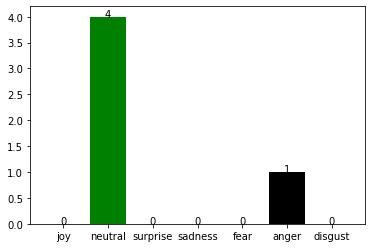

In [44]:
# some code to display emotions in a graph

fig, ax = plt.subplots()

# print(emotions.keys())

emotionList = list(emotions.keys())
valuesList = list(emotions.values())

print(emotionList)
print(valuesList)

ax.bar(emotionList, valuesList)

# show count of each emotion
for i in range(len(emotionList)):
    ax.text(i, valuesList[i], str(valuesList[i]), ha='center')

# different colors for each bar
ax.bar(emotionList, valuesList, color=['red', 'green', 'blue', 'purple', 'orange', 'black', 'pink'])

# label "others" as "neutral"
ax.set_xticklabels(['joy', 'neutral', 'surprise', 'sadness', 'fear', 'anger', 'disgust'])


plt.show()
